## 数据融合与预处理 Data Integration and Preprocessing
多源异构数据整合：作物模型需融合气象数据（温湿度、辐射）、土壤参数（pH值、养分）、遥感影像（多光谱/高光谱）、基因型数据（作物品种）及田间管理记录（灌溉、施肥）。
时空数据处理：采用滑动窗口法处理时间序列数据（如生长周期监测），利用卷积神经网络（CNN）提取遥感图像的空间特征，结合LSTM处理时序依赖性。

一个基于 Python 的示例代码，用于实现上述数据融合与预处理的基本功能。这个示例包含了多源异构数据的模拟整合、滑动窗口法处理时间序列数据、使用 CNN 提取遥感图像空间特征以及结合 LSTM 处理时序依赖性。

### 代码说明：

  

1.  **数据生成**：`generate_synthetic_data` 函数用于生成模拟的多源异构数据，包括气象数据、土壤参数、遥感影像、基因型数据和田间管理记录。
2.  **滑动窗口法**：`sliding_window` 函数实现了滑动窗口法，用于处理时间序列数据。
3.  **CNN 模型**：`CNN` 类定义了一个简单的卷积神经网络，用于提取遥感图像的空间特征。
4.  **LSTM 模型**：`LSTM` 类定义了一个长短期记忆网络，用于处理时序依赖性。
5.  **主函数**：`main` 函数将上述步骤整合在一起，包括数据整合、滑动窗口处理、CNN 特征提取和 LSTM 处理。

### 注意事项：

  

-   这只是一个示例代码，实际应用中需要根据具体的数据格式和任务进行调整。
-   代码中使用了模拟数据，实际应用中需要替换为真实数据。
-   模型的参数（如窗口大小、CNN 和 LSTM 的结构）需要根据具体任务进行调优。

LSTM输出形状: torch.Size([91, 1])


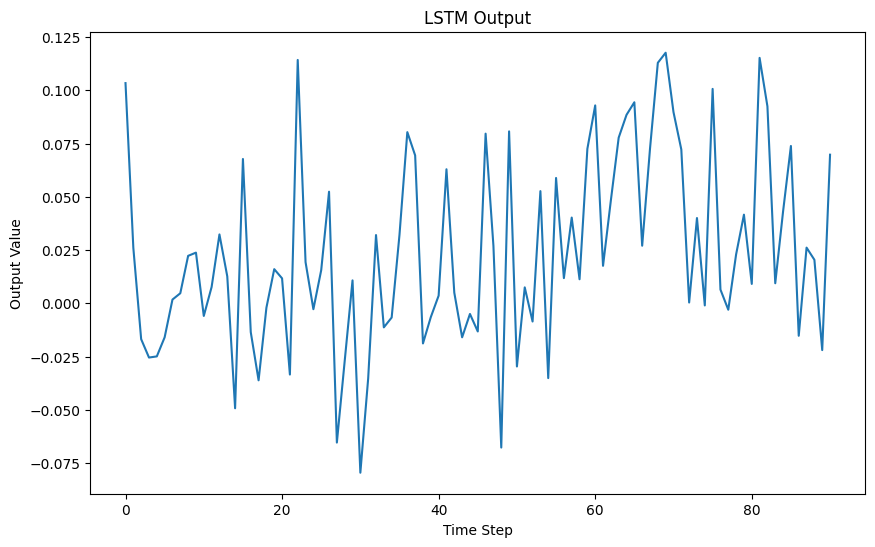

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 模拟多源异构数据
def generate_synthetic_data():
    # 气象数据
    weather_data = pd.DataFrame({
        'temperature': np.random.rand(100),
        'humidity': np.random.rand(100),
        'radiation': np.random.rand(100)
    })
    # 土壤参数
    soil_data = pd.DataFrame({
        'pH': np.random.rand(100),
        'nutrient': np.random.rand(100)
    })
    # 遥感影像
    remote_sensing_data = np.random.rand(100, 3, 32, 32)  # 100张3通道32x32的图像
    # 基因型数据
    genotype_data = pd.DataFrame({
        'crop_variety': np.random.randint(0, 5, 100)
    })
    # 田间管理记录
    field_management_data = pd.DataFrame({
        'irrigation': np.random.rand(100),
        'fertilization': np.random.rand(100)
    })
    return weather_data, soil_data, remote_sensing_data, genotype_data, field_management_data

# 滑动窗口法处理时间序列数据
def sliding_window(data, window_size):
    windows = []
    for i in range(len(data) - window_size + 1):
        windows.append(data[i:i+window_size])
    return np.array(windows)

# 定义CNN模型用于提取遥感图像的空间特征
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc = nn.Linear(32 * 8 * 8, 64)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = self.fc(x)
        return x

# 定义LSTM模型处理时序依赖性
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# 主函数
# def main():
# 生成模拟数据
weather_data, soil_data, remote_sensing_data, genotype_data, field_management_data = generate_synthetic_data()

# 数据整合
combined_data = pd.concat([weather_data, soil_data, genotype_data, field_management_data], axis=1)

# 滑动窗口法处理时间序列数据
window_size = 10
time_series_windows = sliding_window(combined_data.values, window_size)

# 截取遥感数据，使其长度与滑动窗口数据一致
remote_sensing_data = remote_sensing_data[window_size - 1:]

# 准备遥感数据
remote_sensing_tensor = torch.tensor(remote_sensing_data, dtype=torch.float32)

# 初始化CNN模型
cnn = CNN()
# 提取遥感图像的空间特征
spatial_features = cnn(remote_sensing_tensor)

# 结合滑动窗口数据和空间特征
combined_features = np.concatenate([time_series_windows.reshape(-1, window_size * combined_data.shape[1]), spatial_features.detach().numpy()], axis=1)

# 准备LSTM输入
lstm_input = torch.tensor(combined_features, dtype=torch.float32).view(-1, 1, combined_features.shape[1])

# 初始化LSTM模型
input_size = combined_features.shape[1]
hidden_size = 32
num_layers = 1
output_size = 1
lstm = LSTM(input_size, hidden_size, num_layers, output_size)

# 前向传播
output = lstm(lstm_input)
print("LSTM输出形状:", output.shape)

# 绘制LSTM输出结果
output_np = output.detach().numpy().flatten()
plt.figure(figsize=(10, 6))
plt.plot(output_np)
plt.title('LSTM Output')
plt.xlabel('Time Step')
plt.ylabel('Output Value')
plt.show()

# if __name__ == "__main__":
#     main()

### 代码说明：
数据处理部分：和之前一样，生成模拟数据，进行数据整合、滑动窗口处理、CNN 特征提取等操作。
LSTM 部分：初始化 LSTM 模型并进行前向传播得到输出。
增加 可视化部分：
使用 detach().numpy() 将 PyTorch 张量转换为 NumPy 数组。
使用 flatten() 将数组展平为一维数组。
使用 matplotlib.pyplot.plot() 绘制折线图，展示 LSTM 的输出结果。
使用 plt.title()、plt.xlabel() 和 plt.ylabel() 添加图标题、x 轴标签和 y 轴标签。
最后使用 plt.show() 显示图像。